# Deal with imbalanced dataset

This notebook will tackle the problem known as classification with imbalanced classes. We will first introduce the problem and emphasize the difficulties related to both training and evaluating a predictive model under these circumstances.

Let's start to fetch a dataset from OpenML.

In [1]:
from sklearn.datasets import fetch_openml

dataset = fetch_openml(data_id=42397, as_frame=True)
X, y = dataset.data, dataset.target

The ID does not give us too much information regarding this dataset. Let's get some information looking at the related description provided by OpenML.

In [2]:
print(dataset.DESCR)

**Source**: Unknown - Date unknown  
**Please cite**: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015  

Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information a

Thus, we got a bit more information. There is three important information: (i)the dataset is a classification problem to detect credit card frauds; (ii) it is supposidely highly imbalanced; (iii) the features are numerical features resulting from a principal component analysis (PCA) decomposition. Since we don't have a clue regarding the number of original features, we only know that the features `V**` are a linear combination of the original features. Such processing is used to encode the original data but let us the possibility to still work with a surrogate.

Let's have a first look at the dataset then.

In [3]:
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


So in addition of the PCA features, we also have two other features: `"Time"` and `"Amount"` corresponding to the relative time of the transaction and the amount of the transaction, respectively. We can also check the size of the dataset:

In [4]:
X.shape

(284807, 30)

So we have almost 300,000 available samples. Let's now have a look at our target.

In [5]:
y.head()

0    False
1    False
2    False
3    False
4    False
Name: Class, dtype: category
Categories (2, object): ['True', 'False']

The target is a binary target: `True` indicates that the transaction was a fraud while `False` indicates that it as legitimate.

## Problem definition

Before to start training an powerful predictive model, it is always nice to start by having a baseline. Earlier in this course, we notably presented two approaches to get baselines that we expect to be beaten by any predictive model.

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
        <li>Create a dummy predictor that will always predict the most frequent class of the training set.</li>
        <li>Use cross-validation to get an estimate of the test score of such dummy baseline.</li>
        <li>Use the accuracy score as an evaluation metric.</li>
    </ul>
    What can you say about the statistical performance of the model?
</div>

In [6]:
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")
cv_results = cross_validate(dummy_classifier, X, y, n_jobs=-1)
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score
0,0.104676,0.079832,0.998262
1,0.098947,0.087317,0.998262
2,0.095814,0.087114,0.998280
3,0.108059,0.080233,0.998280
4,0.094599,0.094575,0.998280


It looks wonderful. We have a model that is highly accurate. Too accurate to be true. It might be a good idea to have a look at the confusion matrix.

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
        <li>Split the original data to get a training and a testing set.</li>
        <li>Train the previous dummy classifier on the training data.</li>
        <li>Plot the confusion matrix using <tt>ConfusionMatrixDisplay.from_estimator</tt>.</li>
    </ul>
    What can you conclude?
</div>

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0
)

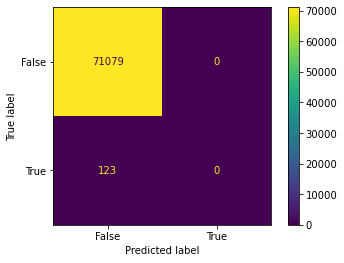

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

dummy_classifier.fit(X_train, y_train)
display = ConfusionMatrixDisplay.from_estimator(
    dummy_classifier, X_test, y_test
)

This is pretty logical indeed. We force our estimator to always predict that there is no fraud. However, since there is a lot of legitimate transactions in regards to the fraudulent transactions, computing the accuracy score will not be helpful at representing a metric answering to the question "How good my predictive model is at detecting credit card fraud?".

Indeed, considering that our "positive" outcomes is detecting frauds, we should use metrics that focuses only on the frauds outcomes.

## Metrics to use in imbalanced classification setting

Before to look at the impact of imbalanced classes on the model, we can first define the metrics that we should use in this setting. It will help to compare models later.

As mentioned earlier, we should use metrics that only focus on the "positive" outcome. Thus, looking at the metrics derived from the confusion matrix, we could be interested in the following:

- recall (also called sensitivity)
- precision
- average precision (area under the curve of the precision-recall curve)
- balanced accuracy

Let's see what these metrics would have give us as indication regarding the statistical performance of our dummy predictive model.

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
        <li>Repeat the cross-validation evaluation by passing the above scores as metrics to be evaluated.</li>
    </ul>
</div>

In [9]:
from sklearn.metrics import make_scorer
from sklearn.metrics import (
    balanced_accuracy_score,
    precision_score,
    recall_score,
    average_precision_score,
)

scoring = {
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "precision": make_scorer(precision_score, pos_label="True"),
    "recall": make_scorer(recall_score, pos_label="True"),
    "average_precision": make_scorer(
        average_precision_score, needs_proba=True, pos_label="True"
    ),
}

cv_results = cross_validate(
    dummy_classifier, X, y, scoring=scoring, n_jobs=-1
)
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_balanced_accuracy,test_precision,test_recall,test_average_precision
0,0.097270,0.763962,0.5,0.0,0.0,0.001738
1,0.098135,0.774631,0.5,0.0,0.0,0.001738
2,0.111174,0.815311,0.5,0.0,0.0,0.001720
3,0.096559,0.763883,0.5,0.0,0.0,0.001720
4,0.107455,0.796515,0.5,0.0,0.0,0.001720


We observe that all scores are reflecting that our model is not good at detecting credit card fraud. Now to have we have a set of sensible metrics, we can go ahead looking at the impact of training a model on an imbalanced dataset.

## Impact of imbalanced classes on the training process

In the remainder of this notebook, we will compare the impact of imbalanced classes on the training process and a couple of strategies allowing to improve and alleviate this issue.

In [10]:
from collections import defaultdict

index = []
scores = defaultdict(list)

In [11]:
def update_scores(scores, cv_results):
    for key in cv_results:
        prefix = "test_"
        if prefix in key:
            scores[key.replace(prefix, "").replace("_", " ").capitalize()].append(
                cv_results[key].mean()
            )
    return scores

### Dummy baseline

Let's store the results of the dummy baseline that we used previously.

In [12]:
classifier = DummyClassifier(strategy="most_frequent")
cv_results = cross_validate(classifier, X, y, scoring=scoring, n_jobs=-1)

In [13]:
index.append(classifier.__class__.__name__)
scores = update_scores(scores, cv_results)

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balanced accuracy,Precision,Recall,Average precision
DummyClassifier,0.5,0.0,0.0,0.001727


### Linear classifier baseline

Now, we will use a linear classifier that is `LogisticRegression` with the default parameter. It will serve us as a baseline to compare future linear predictive models.
As already presented, we will normalize the feature using a `StandardScaler` that is a good practice.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

classifier = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter=1000)
)
cv_results = cross_validate(classifier, X, y, scoring=scoring, n_jobs=-1)

In [15]:
index.append(classifier[-1].__class__.__name__)
scores = update_scores(scores, cv_results)

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balanced accuracy,Precision,Recall,Average precision
DummyClassifier,0.500000,0.000000,0.000000,0.001727
LogisticRegression,0.800512,0.885536,0.601196,0.739402


We observe that our model is indeed learning something. It is much better than the baseline model. However, we will see that it is indeed impacted by the class imbalance and it can do even better.

Now, we will also train a `RandomForestClassifier` in order to have a powerful tree-based model for later comparison as well. `RandomForestClassifier` will not require any preprocessing since we are only dealing with numerical features.

In [16]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_jobs=-1)
cv_results = cross_validate(classifier, X, y, scoring=scoring)

In [17]:
index.append(classifier.__class__.__name__)
scores = update_scores(scores, cv_results)

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balanced accuracy,Precision,Recall,Average precision
DummyClassifier,0.500000,0.000000,0.000000,0.001727
LogisticRegression,0.800512,0.885536,0.601196,0.739402
RandomForestClassifier,0.796670,0.753393,0.790270,0.732701


We observe that `RandomForestClassifier` is also learning something from data. The average precision is lower than for the linear model but the recall is higher.

However, we will see that both models can do both better in terms of metrics by tweaking the training procedure.

### Introduction of `sample_weight`

When we presented boosting algorithm where we used `sample_weight` to tweak the training procedure.

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    Come with a strategy that would use <tt>sample_weight</tt> at <tt>fit</tt> in order to alleviate the issue of class imbalanced. Feel free to use a single split instead of cross-validation to evaluate your approach at first.
</div>

In [18]:
class_ratio = y.value_counts(normalize=True)
class_ratio

False    0.998273
True     0.001727
Name: Class, dtype: float64

In [19]:
import numpy as np

sample_weight = np.zeros_like(y, dtype=np.float64)
sample_weight[y == "True"] = class_ratio["False"]
sample_weight[y == "False"] = class_ratio["True"]

In [20]:
classifier = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter=1000)
)
cv_results = cross_validate(
    classifier, X, y, scoring=scoring, n_jobs=-1,
    fit_params={
        "logisticregression__sample_weight": sample_weight
    }
)
cv_results = pd.DataFrame(cv_results)

In [21]:
cv_results.mean()

fit_time                  0.969100
score_time                1.131283
test_balanced_accuracy    0.930946
test_precision            0.065803
test_recall               0.892228
test_average_precision    0.730541
dtype: float64

While `sample_weight` is providing the flexibility to change any weight for a given sample, scikit-learn provides sometimes a `class_weight` attribute in some estimator that would implement some strategie to reweight samples of the different classes.

### Use `class_weight` instead of `sample_weight`

Most of the models in `scikit-learn` have a parameter `class_weight`. This
parameter will affect the computation of the loss in linear model or the
criterion in the tree-based model to penalize differently a false
classification from the minority and majority class. We can set
`class_weight="balanced"` such that the weight applied is inversely
proportional to the class frequency. We test this parametrization in both
linear model and tree-based model.



In [22]:
classifier = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight="balanced", max_iter=1000),
)
cv_results = cross_validate(
    classifier, X, y, scoring=scoring, n_jobs=-1,
)

In [23]:
index.append(f"{classifier[-1].__class__.__name__} with balanced class weight")
scores = update_scores(scores, cv_results)

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balanced accuracy,Precision,Recall,Average precision
DummyClassifier,0.500000,0.000000,0.000000,0.001727
LogisticRegression,0.800512,0.885536,0.601196,0.739402
RandomForestClassifier,0.796670,0.753393,0.790270,0.732701
LogisticRegression with balanced class weight,0.929240,0.062168,0.892228,0.740864


We see that this parameter has an impact on the overall performance. Looking at the precision and recall, we observe that our model becomes sensitive (it detects most of the fraud) at the cost of false detection. Since the balanced accuracy is an average of the recall of each class, the metric is still high.

In [24]:
classifier = RandomForestClassifier(class_weight="balanced")
cv_results = cross_validate(
    classifier, X, y, scoring=scoring, n_jobs=-1,
)

In [25]:
index.append(f"{classifier.__class__.__name__} with balanced class weight")
scores = update_scores(scores, cv_results)

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balanced accuracy,Precision,Recall,Average precision
DummyClassifier,0.500000,0.000000,0.000000,0.001727
LogisticRegression,0.800512,0.885536,0.601196,0.739402
RandomForestClassifier,0.796670,0.753393,0.790270,0.732701
LogisticRegression with balanced class weight,0.929240,0.062168,0.892228,0.740864
RandomForestClassifier with balanced class weight,0.840155,0.903390,0.680478,0.743878


We can as well see an impact of setting this parameter with `RandomForestClassifier`. With this model, the weights will increase the sensitivity of the model (i.e. increased recall) but with no trade-off on the precision.

An intuition regarding this results and difference with the `LogisticRegression` might be due to the fact that the model is non-linear.

### Resampling instead of passing weights

We saw that the semantic of `sample_weight` would be the following: a weight of 0 will mean that we don't consider the sample while a weight of 2 will be equivalent of having twice the sample in the dataset.

In the case that a model is not providing `sample_weight` and `class_weight` another library called `imbalanced-learn` allows to use an arbritrary resampling strategy in a pipeline. We will use these strategy to show that they are pretty much equivalent to `sample_weight` or `class_weight`. However, they would allow to specify a specific balancing ratio and could even be find by grid-search. 

Note that we are importing `make_pipeline` from `imblearn` because the `Pipeline` from `scikit-learn` will not handle sampler from `imbalanced-learn`.

In [26]:
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import RandomUnderSampler

classifier = make_pipeline_with_sampler(
    StandardScaler(),
    RandomUnderSampler(random_state=42),
    LogisticRegression(max_iter=1000),
)
cv_results = cross_validate(
    classifier, X, y, scoring=scoring, n_jobs=-1,
)

In [27]:
index.append(f"{classifier[-1].__class__.__name__} with {classifier[-2].__class__.__name__}")
scores = update_scores(scores, cv_results)

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balanced accuracy,Precision,Recall,Average precision
DummyClassifier,0.500000,0.000000,0.000000,0.001727
LogisticRegression,0.800512,0.885536,0.601196,0.739402
RandomForestClassifier,0.796670,0.753393,0.790270,0.732701
LogisticRegression with balanced class weight,0.929240,0.062168,0.892228,0.740864
RandomForestClassifier with balanced class weight,0.840155,0.903390,0.680478,0.743878
LogisticRegression with RandomUnderSampler,0.915563,0.042693,0.898330,0.543483


<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    Repeat the experiment above but try to fine tune the balancing ratio by grid-search. Optimize the average precision score. The parameter to tune is called <tt>samling_strategy</tt>. You can refert to the <a href="https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html">documentation</a>.
</div>

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "randomundersampler__sampling_strategy": np.logspace(-3, -1, num=15)
}
classifier = GridSearchCV(
    make_pipeline_with_sampler(
        StandardScaler(),
        RandomUnderSampler(random_state=42),
        LogisticRegression(max_iter=1000),
    ),
    param_grid=param_grid,
    scoring=make_scorer(
        average_precision_score, needs_proba=True, pos_label="True"
    ),
)
cv_results = cross_validate(
    classifier, X, y, scoring=scoring, n_jobs=-1,
    return_estimator=True,
)

In [29]:
for estimator in cv_results["estimator"]:
    print(estimator.best_params_)

{'randomundersampler__sampling_strategy': 0.019306977288832496}
{'randomundersampler__sampling_strategy': 0.019306977288832496}
{'randomundersampler__sampling_strategy': 0.0071968567300115215}
{'randomundersampler__sampling_strategy': 0.005179474679231213}
{'randomundersampler__sampling_strategy': 0.005179474679231213}


In [30]:
index.append("LogisticRegression with RandomUnderSampler with an optimal ratio")
scores = update_scores(scores, cv_results)

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balanced accuracy,Precision,Recall,Average precision
DummyClassifier,0.500000,0.000000,0.000000,0.001727
LogisticRegression,0.800512,0.885536,0.601196,0.739402
RandomForestClassifier,0.796670,0.753393,0.790270,0.732701
LogisticRegression with balanced class weight,0.929240,0.062168,0.892228,0.740864
RandomForestClassifier with balanced class weight,0.840155,0.903390,0.680478,0.743878
LogisticRegression with RandomUnderSampler,0.915563,0.042693,0.898330,0.543483
LogisticRegression with RandomUnderSampler with an optimal ratio,0.885788,0.767201,0.772047,0.753711


We can repeat the previous experiment for the `RandomForestClassifier` and observe the impact of the sampling.

In [31]:
param_grid = {
    "randomundersampler__sampling_strategy": np.logspace(-2, 0, num=15)
}
classifier = GridSearchCV(
    make_pipeline_with_sampler(
        RandomUnderSampler(random_state=42),
        RandomForestClassifier(n_jobs=-1),
    ),
    param_grid=param_grid,
    scoring=make_scorer(
        average_precision_score, needs_proba=True, pos_label="True"
    ),
)
cv_results = cross_validate(
    classifier, X, y, scoring=scoring, return_estimator=True,
)

In [32]:
for estimator in cv_results["estimator"]:
    print(estimator.best_params_)

{'randomundersampler__sampling_strategy': 0.07196856730011521}
{'randomundersampler__sampling_strategy': 0.517947467923121}
{'randomundersampler__sampling_strategy': 0.013894954943731374}
{'randomundersampler__sampling_strategy': 0.013894954943731374}
{'randomundersampler__sampling_strategy': 0.013894954943731374}


In [33]:
index.append("RandomForestClassifier with RandomUnderSampler with an optimal ratio")
scores = update_scores(scores, cv_results)

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balanced accuracy,Precision,Recall,Average precision
DummyClassifier,0.500000,0.000000,0.000000,0.001727
LogisticRegression,0.800512,0.885536,0.601196,0.739402
RandomForestClassifier,0.796670,0.753393,0.790270,0.732701
LogisticRegression with balanced class weight,0.929240,0.062168,0.892228,0.740864
RandomForestClassifier with balanced class weight,0.840155,0.903390,0.680478,0.743878
LogisticRegression with RandomUnderSampler,0.915563,0.042693,0.898330,0.543483
LogisticRegression with RandomUnderSampler with an optimal ratio,0.885788,0.767201,0.772047,0.753711
RandomForestClassifier with RandomUnderSampler with an optimal ratio,0.826648,0.514151,0.851288,0.729608


### Integrating sampling within ensemble methods

Some methods based on ensemble are integrating some inner resampling that lead to more efficient algorithms. There are notably two algorithms. Let's start to show `BalancedRandomForestClassifier`.

In [34]:
from imblearn.ensemble import BalancedRandomForestClassifier

classifier = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)
cv_results = cross_validate(
    classifier, X, y, scoring=scoring,
)

Since the resampling happen at the level of the bootstrap, each tree in the forest is created on a lower number of samples. It will lower the computational cost. Resampling each bootstrap will also allow to potentially see more of the original data than with a strategy that resample the full training set before hand.

In [35]:
index.append(classifier.__class__.__name__)
scores = update_scores(scores, cv_results)

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balanced accuracy,Precision,Recall,Average precision
DummyClassifier,0.500000,0.000000,0.000000,0.001727
LogisticRegression,0.800512,0.885536,0.601196,0.739402
RandomForestClassifier,0.796670,0.753393,0.790270,0.732701
LogisticRegression with balanced class weight,0.929240,0.062168,0.892228,0.740864
RandomForestClassifier with balanced class weight,0.840155,0.903390,0.680478,0.743878
LogisticRegression with RandomUnderSampler,0.915563,0.042693,0.898330,0.543483
LogisticRegression with RandomUnderSampler with an optimal ratio,0.885788,0.767201,0.772047,0.753711
RandomForestClassifier with RandomUnderSampler with an optimal ratio,0.826648,0.514151,0.851288,0.729608
BalancedRandomForestClassifier,0.921138,0.053662,0.908411,0.761745


It is as well possible to fine the ratio of the internal resampling as we previously did.

In [36]:
param_grid = {
    "sampling_strategy": np.logspace(-2, 0, num=10)
}
classifier = GridSearchCV(
    BalancedRandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring=make_scorer(
        average_precision_score, needs_proba=True, pos_label="True"
    ),
    
)
cv_results = cross_validate(
    classifier, X, y, scoring=scoring,
)

In [37]:
index.append("BalancedRandomForestClassifier with optimal ratio")
scores = update_scores(scores, cv_results)

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balanced accuracy,Precision,Recall,Average precision
DummyClassifier,0.500000,0.000000,0.000000,0.001727
LogisticRegression,0.800512,0.885536,0.601196,0.739402
RandomForestClassifier,0.796670,0.753393,0.790270,0.732701
LogisticRegression with balanced class weight,0.929240,0.062168,0.892228,0.740864
RandomForestClassifier with balanced class weight,0.840155,0.903390,0.680478,0.743878
LogisticRegression with RandomUnderSampler,0.915563,0.042693,0.898330,0.543483
LogisticRegression with RandomUnderSampler with an optimal ratio,0.885788,0.767201,0.772047,0.753711
RandomForestClassifier with RandomUnderSampler with an optimal ratio,0.826648,0.514151,0.851288,0.729608
BalancedRandomForestClassifier,0.921138,0.053662,0.908411,0.761745
BalancedRandomForestClassifier with optimal ratio,0.827981,0.546700,0.851288,0.762562


In addition of the `BalancedRandomForestClassifier`, `imbalanced-learn` provides a `BalancedBaggingClassifier` that accepts any kind of estimator. Each estimator will be trained on a resampled bootstrap. Here, we show that we could use a strong learner like an `HistGradientBoostingClassifier`.

In [38]:
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

param_grid = {
    "sampling_strategy": np.logspace(-2.1, 0, num=10)
}
classifier = GridSearchCV(
    BalancedBaggingClassifier(
        base_estimator=HistGradientBoostingClassifier(max_iter=1_000, early_stopping=True, random_state=42),
        n_estimators=5,
        random_state=42,
    ),
    param_grid=param_grid,
    scoring=make_scorer(
        average_precision_score, needs_proba=True, pos_label="True"
    ),
)
cv_results = cross_validate(
    classifier, X, y, scoring=scoring, n_jobs=-1
)

In [39]:
index.append("BalancedBaggingClassifier with optimal ratio")
scores = update_scores(scores, cv_results)

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Balanced accuracy,Precision,Recall,Average precision
DummyClassifier,0.500000,0.000000,0.000000,0.001727
LogisticRegression,0.800512,0.885536,0.601196,0.739402
RandomForestClassifier,0.796670,0.753393,0.790270,0.732701
LogisticRegression with balanced class weight,0.929240,0.062168,0.892228,0.740864
RandomForestClassifier with balanced class weight,0.840155,0.903390,0.680478,0.743878
LogisticRegression with RandomUnderSampler,0.915563,0.042693,0.898330,0.543483
LogisticRegression with RandomUnderSampler with an optimal ratio,0.885788,0.767201,0.772047,0.753711
RandomForestClassifier with RandomUnderSampler with an optimal ratio,0.826648,0.514151,0.851288,0.729608
BalancedRandomForestClassifier,0.921138,0.053662,0.908411,0.761745
BalancedRandomForestClassifier with optimal ratio,0.827981,0.546700,0.851288,0.762562


/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/glemaitre/mambaforge/envs/teac

The last approach is probably the most effective but request a huge amount of resource since it relies on powerful models.

However keep in mind that whatever we did here was to optimize a given metric. Is the metric choosen the right one?

## Cost-sensitive metric

Since we are dealing with a business oriented dataset, it might be interested to ask ourselve if the metrics chosen to optimized our model previously were also meaningful for our application (business).

Let's define a real cost-driven metric based on the confusion matrix. We will compute the confusion matrix given us the true positive and negative and the false positive en negative. We will then apply some business rules (completely arbitrary) to convert it into a monetary cost/benefit metric.

In short, we could have the following rules:

- not detecting a fraud will cost us the amount of the transaction
- detecting a fraud will benefit us 20 euros
- refusing a legitimate transaction will annoy our customer and cost us 20 euros
- accepting a legitimate transaction will increase customer confidence and the benefit will depend of the transaction amount

In [73]:
def benefit_matrix(estimator, X, y):
    y_pred = estimator.predict(X)
    tp = (y == "True") & (y == y_pred)
    tn = (y == "False") & (y == y_pred)
    fp = (y_pred == "True") & (y != y_pred)
    fn = (y_pred == "False") & (y != y_pred)
    
    # transform into benefit matrix
    # little benefit when accepting a true transaction
    # it will be related to the amount
    tn_benefit = (X["Amount"][tn] * 0.02).sum()
    # detecting a fraud is not trivial and arbritary
    tp_benefit = tp.sum() * 20
    # blocking a legitimate transaction will annoy our
    # customer
    fp_benefit = fp.sum() * -20
    # not blocking a fraud will cost us the transaction
    # money
    fn_benefit = -(X["Amount"][fn]).sum()
    return {
        "tp_benefit": tp_benefit,
        "tn_benefit": tn_benefit,
        "fp_benefit": fp_benefit,
        "fn_benefit": fn_benefit,
    }

So now that we have our business metric, we can evalutate them.

In [74]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)
cv_results = cross_validate(
    model, X, y, scoring=benefit_matrix, n_jobs=-1, error_score="raise"
)
cv_results = pd.DataFrame(cv_results)

In [76]:
metric_names = [name for name in cv_results.columns if "test_" in name]
cv_results[metric_names]

,test_tp_benefit,test_tn_benefit,test_fp_benefit,test_fn_benefit
0,1540,107860.0006,-660,-1995.30
1,1260,107876.2120,-40,-4338.05
2,840,81607.5532,-80,-10062.68
3,1340,115083.0694,-140,-7670.37
4,940,88660.8090,-60,-8089.81


In [91]:
cv_results[metric_names].sum(axis=1).mean()

97730.42656

Now, we can try to evalute a model where we will resample the dataset. To select the sampling rate, we will maximize the total benefit instead of the average precision that we earlier used.

In [81]:
def total_benefit(estimator, X, y):
    return sum(benefit_matrix(estimator, X, y).values())


param_grid = {
    "randomundersampler__sampling_strategy": np.logspace(-2.1, -1, num=15)
}
classifier = GridSearchCV(
    make_pipeline_with_sampler(
        StandardScaler(),
        RandomUnderSampler(random_state=42),
        LogisticRegression(max_iter=1000),
    ),
    param_grid=param_grid,
    scoring=total_benefit,
    n_jobs=-1
)
cv_results = cross_validate(
    classifier, X, y, scoring=benefit_matrix, return_estimator=True,
)
cv_results = pd.DataFrame(cv_results)

In [85]:
cv_results[metric_names].sum(axis=1).mean()

97853.06096

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    Repeat the above experiment. However, optimize the balanced accuracy within the grid-search. Is it better or worse than optimising in terms of final business metric?
</div>

In [99]:
param_grid = {
    "randomundersampler__sampling_strategy": np.logspace(-2.5, 0, num=15)
}
classifier = GridSearchCV(
    make_pipeline_with_sampler(
        StandardScaler(),
        RandomUnderSampler(random_state=42),
        LogisticRegression(max_iter=1000),
    ),
    param_grid=param_grid,
    scoring="balanced_accuracy",
    n_jobs=-1
)
cv_results = cross_validate(
    classifier, X, y, scoring=benefit_matrix, return_estimator=True,
)
cv_results = pd.DataFrame(cv_results)

In [100]:
cv_results[metric_names].sum(axis=1).mean()

46247.5634

In [101]:
for estimator in cv_results["estimator"]:
    print(estimator.best_params_)

{'randomundersampler__sampling_strategy': 0.6628703161826448}
{'randomundersampler__sampling_strategy': 0.43939705607607904}
{'randomundersampler__sampling_strategy': 0.43939705607607904}
{'randomundersampler__sampling_strategy': 0.6628703161826448}
{'randomundersampler__sampling_strategy': 0.19306977288832505}
